### 21COC102 - Advanced AI Systems

#### Coursework Submission - Joe Cunningham

The purpose of this coursework is to demonstrate different deep neural network architectures on an image classification
problem.

The dataset used in this project is [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html), comprising 60000 3x32x32
images with 10 classes

In [104]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F

import matplotlib.pyplot as plt

# I have gpu access for training, but models should be compatible with CPU
# Hence, check for a GPU:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} for computation")

NUM_CLASSES = 10
CLASS_NAMES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Using cuda for computation


Download the CIFAR-10 dataset & create dataloaders. Adapted from the pytorch quickstart guide
[\[1\]](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html)

In [105]:
CIFAR_train = datasets.CIFAR10(
    root = 'CIFAR-10',
    train = True,
    transform = ToTensor(),
    download=True
)

CIFAR_test = datasets.CIFAR10(
    root = 'CIFAR-10',
    train = False,
    transform = ToTensor(),
    download=True
)

batch_size = 64

train_dataloader = DataLoader(CIFAR_train, batch_size=batch_size)
test_dataloader = DataLoader(CIFAR_test, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


### Training and evaluataion functions

In this section, a train and test function is defined to iterate over the dataset (a single epoch).
These are put together to loop until the train error starts to increase two epochs in a row (early stopping).
The test function uses two helper functions, to compute a class-wise confusion matrix, and then
use this information to compute class-wise precision and recall metrics.

The output of the train/test loop is saved so that it can be plotted using MatPlotLib.

The core train and test functions are adapted from the PyTorch quickstart tutorial [\[1\]](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html)

In [99]:
# Compute a confusion matrix for a single batch
def compute_confusion_matrix(pred_classes, gt_classes, num_classes):
    confusion_matrix = torch.zeros(num_classes, num_classes) #Empty confusion matrix
    for i in range(pred_classes.shape[0]):
        confusion_matrix[pred_classes[i],gt_classes[i]] += 1 #Rows: predicted, Cols: True
    return confusion_matrix

# Use the confusion matrix to compute precision and recall for each class
def compute_precision_recall(confusion_matrix, print_output=False):
    num_classes = confusion_matrix.shape[0]
    class_precision_recall = torch.zeros(num_classes,2) #Row1: Precision, Row2: Recall
    for i in range(num_classes):
        true_pos = confusion_matrix[i,i] #True positive
        precision = true_pos / confusion_matrix[i,:].sum() #TP/Class row
        recall = true_pos / confusion_matrix[:,i].sum() #TP/Class col
        class_precision_recall[i,0] = precision
        class_precision_recall[i,1] = recall
        if print_output: print(f"Class: {i}, Precision: {precision*100:.2f}%, Recall: {recall*100:.2f}")
    avg_precision = class_precision_recall[:,0].sum()/num_classes #Todo: Dont assume an evenly distributed number of classes
    avg_recall = class_precision_recall[:,1].sum()/num_classes
    if print_output: print(f"Average Precision: {avg_precision*100:.2f}%, Average Recall: {avg_recall*100:.2f}%")
    return class_precision_recall, avg_precision, avg_recall


# Setup training/test functions
# Adapted from the pytorch quickstart guide
# https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

def train(dataloader, model, loss_fn, optimiser:torch.optim.Optimizer):
    size = len(dataloader.dataset)
    train_loss = 0 # For graphing the change in loss over time
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y, = X.to(device), y.to(device) #Must be on same device as model
        # Compute preds and loss for batch
        preds = model(X)
        loss = loss_fn(preds,y)

        #Backprop
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        loss = loss.item()
        train_loss += loss * len(X) #Weight the average to account for the last batch

        #Progress tracking
        if batch % 100 == 0:
            current = batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    train_loss /= size #Average loss over the whole epoch
    print(f"Average loss this epoch: {train_loss:>7f}")
    return train_loss

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0,0
    #Start confusion matrix for whole epoch
    confusion_matrix = torch.zeros(NUM_CLASSES, NUM_CLASSES)
    with torch.no_grad(): #Switch off grad during eval
        for X, y in dataloader:
            X, y, = X.to(device), y.to(device)
            preds = model(X)
            test_loss += loss_fn(preds, y).item() * len(X) #Weight the average
            pred_classes = preds.argmax(1)
            confusion_matrix += compute_confusion_matrix(pred_classes, y, NUM_CLASSES)
            correct += (pred_classes == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    class_precision_recall, avg_precision, avg_recall = compute_precision_recall(confusion_matrix, print_output=True)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return [test_loss, correct, confusion_matrix, class_precision_recall,avg_precision, avg_recall]


#loop train/test until test loss gets worse two epochs in a row

def train_with_early_stopping(train_dataloader, test_dataloader, model, loss_fn, optimiser, save_interval=2, min_epochs=2):

    stop, epoch = False, 1
    train_losses, test_results, test_losses = [], [], []
    while not stop:
        print(f"---------- Epoch {epoch} ---------")
        train_losses.append(train(train_dataloader, model, loss_fn, optimiser)) #Train
        test_result = test(test_dataloader, model, loss_fn) #Test
        # Collate test results
        test_results.append(test_result)
        test_losses.append(test_result[0])

        #Save model
        if epoch % save_interval == 0:
            filename = f"{model.name}_{epoch}.pth"
            torch.save(model.state_dict(), filename)

        #check if current test loss is worse than last 2 epochs
        if epoch > min_epochs and epoch > 2:
            check1 = test_losses[-1] > test_losses[-2]
            check2 = test_losses[-1] > test_losses[-3]
            if check1 and check2:
                stop = True
                print(f"Early stopping triggered at epoch {epoch}. Done!")
        # next epoch
        epoch += 1
    return train_losses, test_results


# Plot the results of a training session using pyplotlib
# Currently plotting the following:
#  - Training loss vs Test loss
#  - Average precision, recall, and accuracy (test set)
#  - Precision per class
#  - Recall per class
def plot_results(train_losses, test_results):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)

    # Plot TrainLoss on ax1
    xs, ys = [], []
    for epoch, loss in enumerate(train_losses):
        xs.append(epoch+1)
        ys.append(loss)

    ax1.plot(xs, ys, label="Train Loss")

    # Plot TestLoss on ax1
    test_losses = [i[0] for i in test_results]
    xs, ys = [], []
    for epoch, loss in enumerate(test_losses):
        xs.append(epoch+1)
        ys.append(loss)
    ax1.plot(xs, ys, label="Test Loss")

    # Setup ax1 to show test vs train loss
    ax1.legend()
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.set_title("Test vs. Train Loss")

    # Plot avg precision (ax2)
    ys = [i[4]*100 for i in test_results]
    ax2.plot(xs, ys, label='Precision')

    # Plot avg recall (ax2)
    ys = [i[5]*100 for i in test_results]
    ax2.plot(xs, ys, label='Recall')

    # Setup ax2
    ax2.legend()
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Percentage")
    ax2.set_title("Average Precision/Recall")

    # Show per class precision/recall (ax3/4)
    precision_recalls = [i[3] for i in test_results]
    xs = [i+1 for i in range(len(precision_recalls))]
    for idx, class_name in enumerate(CLASS_NAMES):
        ys_p, ys_r = [],[]
        for p_r in precision_recalls:
            ys_p.append(p_r[idx, 0]*100)
            ys_r.append(p_r[idx, 1]*100)
        # Precision on ax3, recall on ax4
        ax3.plot(xs, ys_p, label=class_name)
        ax4.plot(xs, ys_r, label=class_name)
    # Setup ax3,4
    ax3.legend()
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("Percentage")
    ax3.set_title("Per Class Precision")
    ax4.legend()
    ax4.set_xlabel("Epoch")
    ax4.set_ylabel("Percentage")
    ax4.set_title("Per Class Recall")
    
    #Setup fig
    fig.set_figwidth(20)


### Fully Connected Neural Networks

The first type of neural network to experiment with is the fully connected network. This network comprises several 1-D
layers of neurons, where every neuron in one layer is connected to every neuron in the following layer. The following
network, `FullyConnectedNetwork`, has a configurable number of layers and activations, plus optional batch norm. An activation function is placed between each layer to introduce non-linearity.

Adapted from the pytorch quickstart guide
[\[1\]](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html).

In [100]:
class FullyConnectedNetwork(nn.Module):
    def __init__(self, config:dict):
        super(FullyConnectedNetwork, self).__init__()
        self.name = config['name']

        self.flatten = nn.Flatten()

        layers = config['layer_sizes']
        act_func = config['activation_function']
        batch_norm = config['batch_norm']

        self.linear_stack = nn.Sequential()
        for i in range(len(layers)-1):
            self.linear_stack.append(nn.Linear(layers[i][0],layers[i][1]))
            if batch_norm: self.linear_stack.append(nn.BatchNorm1d(layers[i][1]))
            self.linear_stack.append(act_func)
        # Add last layer without a following activation function
        self.linear_stack.append(nn.Linear(layers[-1][0], layers[-1][1]))


    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_stack(x)
        return x

### Convolutional Neural Networks

The first network `AlexNet32x32`, is based on AlexNet, but scaled down to a 32x32 input. The number of features is configurable for experimentation. Batch norm is optional.

Adapted from the PyTorch 'Training a Classifer' tutorial [\[2\]](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

In [101]:
class AlexNet32x32(nn.Module):
    def __init__(self, config:dict):
        super(AlexNet32x32, self).__init__()
        self.name = config['name']
        batch_norm = config['batch_norm']

        sf = config['small_features']
        mf = config['medium_features']
        lf = config['large_features']
        fcf = config['fullyconnected_features']

        self.conv_stack = nn.Sequential(
            nn.Conv2d(3, sf, 7, 2), # 32x32 -> 13x13, Stride reduced from 4 to 2
            nn.BatchNorm2d(sf) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(3, 1, padding=1), # 13x13 -> 13x13, no stride, added 1 pad
            nn.Conv2d(sf,mf,5,padding="same"), # 13x13 -> 13x13
            nn.BatchNorm2d(mf) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(3, 1), # 13x13 -> 12x12, no stride
            nn.Conv2d(mf, lf, 3, padding="same"), # 12x12
            nn.BatchNorm2d(lf) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.Conv2d(lf, lf, 3, padding="same"), # 12x12, 
            nn.BatchNorm2d(lf) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.Conv2d(lf, mf, 3, padding="same"), # 12x12
            nn.BatchNorm2d(mf) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2) # 12x12 -> 5x5
        )

        self.fc_stack = nn.Sequential(
            nn.Linear(5*5*mf, fcf),
            nn.BatchNorm1d(fcf) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(fcf, fcf),
            nn.BatchNorm1d(fcf) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(fcf, 10)
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = torch.flatten(x, 1)
        x = self.fc_stack(x)
        return x

This second CNN, `VGG1632x32`, is based on VGG16, but one max pooling layer has changed to ensure the
size is not reduced below 3x3. The number of features is configurable for experimentation.
Batch norm is optional.

Adapted from Rohit Thakur's 'VGG16 implementation in Keras' article [\[3\]](https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c).

In [102]:
class VGG1632x32(nn.Module):
    def __init__(self, config:dict):
        super(VGG1632x32, self).__init__()

        self.name = config['name']
        batch_norm = config['batch_norm']
        
        c1f = config['conv1_features']
        c2f = config['conv2_features']
        c3f = config['conv3_features']
        c4f = config['conv4_features']
        c5f = config['conv5_features']
        fcf = config['fullyconnected_features']

        self.conv_stack = nn.Sequential(
            # Conv stack 1 - 2 layers c1f features
            nn.Conv2d(3,c1f,3,padding='same'), # 32x32
            nn.BatchNorm2d(c1f) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.Conv2d(c1f,c1f,3,padding='same'), # 32x32
            nn.BatchNorm2d(c1f) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 32x32 -> 16x16
            
            # Conv stack 2 - 2 layers 128 features
            nn.Conv2d(c1f,c2f,3,padding='same'), # 16x16
            nn.BatchNorm2d(c2f) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.Conv2d(c2f,c2f,3,padding='same'), # 16x16
            nn.BatchNorm2d(c2f) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 16x16 -> 8x8
            
            # Conv stack 3 - 3 layers c3f features
            nn.Conv2d(c2f,c3f,3,padding='same'), # 8x8
            nn.BatchNorm2d(c3f) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.Conv2d(c3f,c3f,3,padding='same'), # 8x8
            nn.BatchNorm2d(c3f) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.Conv2d(c3f,c3f,3,padding='same'), # 8x8
            nn.BatchNorm2d(c3f) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.Conv2d(c3f,c3f,3,padding='same'), # 8x8
            nn.BatchNorm2d(c3f) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #  8x8 -> 4x4
            
            # Conv stack 4 - 3 layers c4f features
            nn.Conv2d(c3f,c4f,3,padding='same'), # 4x4
            nn.BatchNorm2d(c4f) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.Conv2d(c4f,c4f,3,padding='same'), # 4x4
            nn.BatchNorm2d(c4f) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.Conv2d(c4f,c4f,3,padding='same'), # 4x4
            nn.BatchNorm2d(c4f) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.Conv2d(c4f,c4f,3,padding='same'), # 4x4
            nn.BatchNorm2d(c4f) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(2, 1, padding=1), #  4x4 -> 4x4
            
            # Conv stack 5 - 3 layers c5f features
            nn.Conv2d(c4f,c5f,3,padding='same'),# 4x4
            nn.BatchNorm2d(c5f) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.Conv2d(c5f,c5f,3,padding='same'), # 4x4
            nn.BatchNorm2d(c5f) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.Conv2d(c5f,c5f,3,padding='same'), # 4x4
            nn.BatchNorm2d(c5f) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(2, 2) #2x2x512
        )

        self.fc_stack = nn.Sequential(
            nn.Linear(2*2*c5f, fcf),
            nn.BatchNorm1d(fcf) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.Linear(fcf, fcf),
            nn.BatchNorm1d(fcf) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.Linear(fcf, 10)
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = torch.flatten(x, 1)
        x = self.fc_stack(x)
        return x

### Training and Evaluating Models

The following section will train and evaluate the above models under various conditions, with evaluation metrics plotted below each one.

#### `FullyConnectedNetwork` , Large Learning Rate

FullyConnectedNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
---------- Epoch 1 ---------
loss: 2.303466  [    0/50000]
loss: 2.110348  [ 6400/50000]
loss: 1.837518  [12800/50000]
loss: 1.885139  [19200/50000]
loss: 2.012432  [25600/50000]
loss: 1.931153  [32000/50000]
loss: 1.866110  [38400/50000]
loss: 1.793809  [44800/50000]
Average loss this epoch: 1.926928
Class: 0, Precision: 53.19%, Recall: 34.20
Class: 1, Precision: 22.24%, Recall: 73.20
Class: 2, Precision: 22.69%, Recall: 4.90
Class: 3, Precision: 35.29%, Recall: 3.00
Class: 4, Precision: 25.18%, Recall: 44.40
Class: 5, Precision: 55.62%, Recall: 9.90
Class: 6, Precision: 30.25%, Recall: 65.70
Class: 7, Precision: 41.96%, Recall: 26.10
Class: 8, Precision: 80.49%, Reca

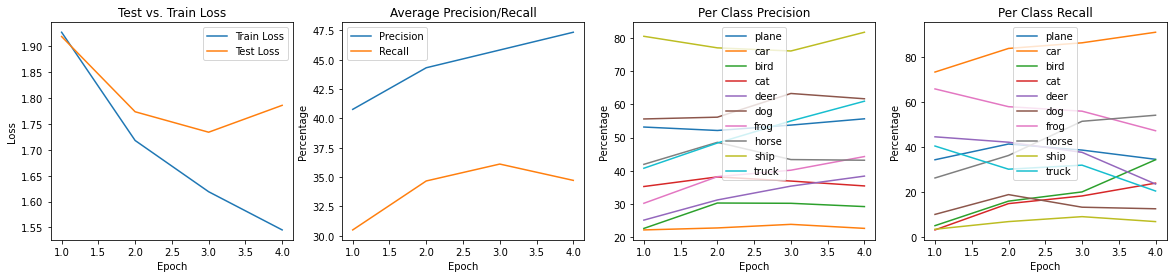

In [103]:
fc_net_config = {
    'name' : 'FullyConnectedNetwork_1x512_LR1e-1',
    'layer_sizes' : [(3*32*32,512),(512,512),(512,10)],
    'activation_function' : nn.ReLU(),
    'batch_norm' : False
}
fc_net = FullyConnectedNetwork(fc_net_config).to(device)
print(fc_net)

loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(fc_net.parameters(), lr=1e-1)

train_losses, test_results = train_with_early_stopping(train_dataloader, test_dataloader, fc_net, loss_fn, optimiser)

plot_results(train_losses, test_results)

#### `FullyConnectedNetwork`, Small Learning Rate with Momentum

FullyConnectedNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
---------- Epoch 1 ---------
loss: 2.293301  [    0/50000]
loss: 2.281399  [ 6400/50000]
loss: 2.190669  [12800/50000]
loss: 2.192609  [19200/50000]
loss: 2.077297  [25600/50000]
loss: 2.049158  [32000/50000]
loss: 2.142377  [38400/50000]
loss: 1.946042  [44800/50000]
Average loss this epoch: 2.113404
Class: 0, Precision: 38.74%, Recall: 32.50
Class: 1, Precision: 27.81%, Recall: 30.40
Class: 2, Precision: 37.50%, Recall: 0.90
Class: 3, Precision: 19.66%, Recall: 17.40
Class: 4, Precision: 38.10%, Recall: 0.80
Class: 5, Precision: 23.89%, Recall: 41.90
Class: 6, Precision: 27.66%, Recall: 46.80
Class: 7, Precision: 28.30%, Recall: 25.50
Class: 8, Precision: 34.01%, Rec

loss: 1.523154  [ 6400/50000]
loss: 1.260772  [12800/50000]
loss: 1.614914  [19200/50000]
loss: 1.501640  [25600/50000]
loss: 1.596748  [32000/50000]
loss: 1.678103  [38400/50000]
loss: 1.480018  [44800/50000]
Average loss this epoch: 1.486181
Class: 0, Precision: 51.92%, Recall: 55.30
Class: 1, Precision: 46.92%, Recall: 73.20
Class: 2, Precision: 37.65%, Recall: 22.10
Class: 3, Precision: 30.74%, Recall: 46.70
Class: 4, Precision: 51.98%, Recall: 23.60
Class: 5, Precision: 39.64%, Recall: 35.00
Class: 6, Precision: 47.48%, Recall: 53.70
Class: 7, Precision: 51.03%, Recall: 54.70
Class: 8, Precision: 63.68%, Recall: 55.40
Class: 9, Precision: 55.06%, Recall: 47.30
Average Precision: 47.61%, Average Recall: 46.70%
Test Error: 
 Accuracy: 46.7%, Avg loss: 1.502635 

---------- Epoch 12 ---------
loss: 1.509676  [    0/50000]
loss: 1.510270  [ 6400/50000]
loss: 1.236898  [12800/50000]
loss: 1.588530  [19200/50000]
loss: 1.468066  [25600/50000]
loss: 1.574392  [32000/50000]
loss: 1.667708

loss: 1.348217  [ 6400/50000]
loss: 1.143746  [12800/50000]
loss: 1.400548  [19200/50000]
loss: 1.250631  [25600/50000]
loss: 1.421347  [32000/50000]
loss: 1.484516  [38400/50000]
loss: 1.341409  [44800/50000]
Average loss this epoch: 1.296995
Class: 0, Precision: 59.38%, Recall: 59.80
Class: 1, Precision: 55.64%, Recall: 74.50
Class: 2, Precision: 45.86%, Recall: 28.80
Class: 3, Precision: 33.63%, Recall: 45.00
Class: 4, Precision: 52.97%, Recall: 32.10
Class: 5, Precision: 38.20%, Recall: 42.90
Class: 6, Precision: 56.75%, Recall: 53.80
Class: 7, Precision: 56.16%, Recall: 58.80
Class: 8, Precision: 66.74%, Recall: 61.20
Class: 9, Precision: 54.44%, Recall: 57.00
Average Precision: 51.98%, Average Recall: 51.39%
Test Error: 
 Accuracy: 51.4%, Avg loss: 1.382633 

---------- Epoch 22 ---------
loss: 1.327394  [    0/50000]
loss: 1.345944  [ 6400/50000]
loss: 1.139826  [12800/50000]
loss: 1.385791  [19200/50000]
loss: 1.234302  [25600/50000]
loss: 1.412369  [32000/50000]
loss: 1.469373

loss: 1.209223  [ 6400/50000]
loss: 1.064896  [12800/50000]
loss: 1.269049  [19200/50000]
loss: 1.066533  [25600/50000]
loss: 1.329105  [32000/50000]
loss: 1.305090  [38400/50000]
loss: 1.241102  [44800/50000]
Average loss this epoch: 1.156395
Class: 0, Precision: 63.58%, Recall: 56.90
Class: 1, Precision: 58.84%, Recall: 73.20
Class: 2, Precision: 50.00%, Recall: 32.10
Class: 3, Precision: 34.24%, Recall: 46.80
Class: 4, Precision: 49.88%, Recall: 40.10
Class: 5, Precision: 44.85%, Recall: 40.90
Class: 6, Precision: 62.75%, Recall: 53.40
Class: 7, Precision: 54.11%, Recall: 65.10
Class: 8, Precision: 66.49%, Recall: 64.30
Class: 9, Precision: 53.81%, Recall: 60.00
Average Precision: 53.85%, Average Recall: 53.28%
Test Error: 
 Accuracy: 53.3%, Avg loss: 1.331196 

---------- Epoch 32 ---------
loss: 1.155290  [    0/50000]
loss: 1.215059  [ 6400/50000]
loss: 1.054952  [12800/50000]
loss: 1.256987  [19200/50000]
loss: 1.064491  [25600/50000]
loss: 1.315986  [32000/50000]
loss: 1.276839

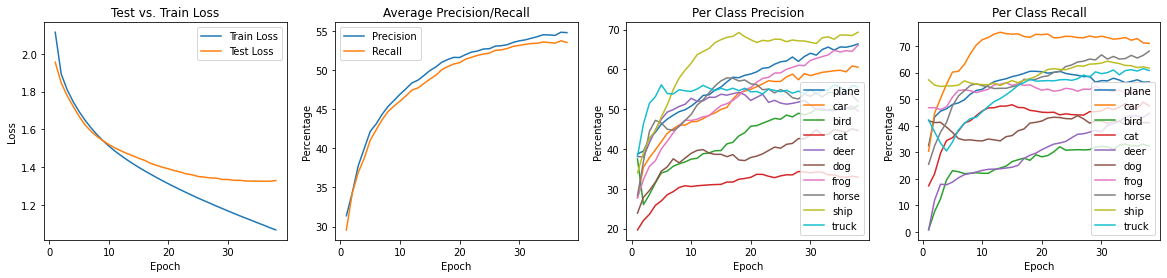

In [107]:
# Note: We are resuing names to conserve VRAM
fc_net_config = {
    'name' : 'FullyConnectedNetwork_1x512_LR1e-3_M09',
    'layer_sizes' : [(3*32*32,512),(512,512),(512,10)],
    'activation_function' : nn.ReLU(),
    'batch_norm' : False
}
fc_net = FullyConnectedNetwork(fc_net_config).to(device)
print(fc_net)

loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(fc_net.parameters(), lr=1e-3, momentum=0.9)

train_losses, test_results = train_with_early_stopping(train_dataloader, test_dataloader, fc_net, loss_fn, optimiser)

plot_results(train_losses, test_results)

#### `FullyConnectedNetwork`, with Batch Normalisation

FullyConnectedNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=10, bias=True)
  )
)
---------- Epoch 1 ---------
loss: 2.407994  [    0/50000]
loss: 1.805585  [ 6400/50000]
loss: 1.376792  [12800/50000]
loss: 1.731983  [19200/50000]
loss: 1.599081  [25600/50000]
loss: 1.683405  [32000/50000]
loss: 1.696486  [38400/50000]
loss: 1.431587  [44800/50000]
Average loss this epoch: 1.636963
Class: 0, Precision: 59.93%, Recall: 51.30
Class: 1, Precision: 55.05%, Recall: 63.20
Class: 2, Precision: 40.54%, Recall: 32.80
Class: 3, Precision: 30.95%, Recall: 45.00
Class: 4, Precision: 4

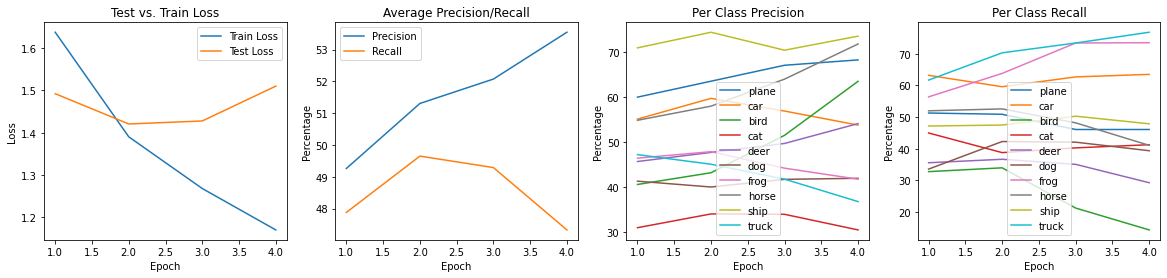

In [108]:
fc_net_config = {
    'name' : 'FullyConnectedNetwork_1x512_LR1e-3_M09_BN',
    'layer_sizes' : [(3*32*32,512),(512,512),(512,10)],
    'activation_function' : nn.ReLU(),
    'batch_norm' : True
}
fc_net = FullyConnectedNetwork(fc_net_config).to(device)
print(fc_net)

loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(fc_net.parameters(), lr=1e-3, momentum=0.9)

train_losses, test_results = train_with_early_stopping(train_dataloader, test_dataloader, fc_net, loss_fn, optimiser)

plot_results(train_losses, test_results)

#### `FullyConnectedNetwork`, Large Number of Features

FullyConnectedNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_stack): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=1024, out_features=10, bias=True)
  )
)
---------- Epoch 1 ---------
loss: 2.348239  [    0/50000]
loss: 1.697733  [ 6400/50000]
loss: 1.321730  [12800/50000]
loss: 1.682410  [19200/50000]
loss: 1.560459  [25600/50000]
loss: 1.700649  [32000/50000]
loss: 1.631846  [38400/50000]
loss: 1.403042  [44800/50000]
Average loss this epoch: 1.593370
Class: 0, Precisi

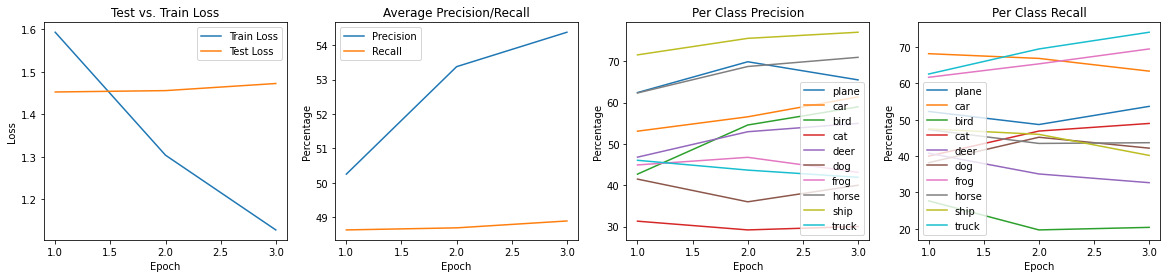

In [109]:
fc_net_config = {
    'name' : 'FullyConnectedNetwork_2x1024_LR1e-3_M09_BN',
    'layer_sizes' : [(3*32*32,1024),(1024,1024),(1024,1024),(1024,10)],
    'activation_function' : nn.ReLU(),
    'batch_norm' : True
}
fc_net = FullyConnectedNetwork(fc_net_config).to(device)
print(fc_net)

loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(fc_net.parameters(), lr=1e-3, momentum=0.9)

train_losses, test_results = train_with_early_stopping(train_dataloader, test_dataloader, fc_net, loss_fn, optimiser)

plot_results(train_losses, test_results)

#### `FullyConnectedNetwork`, Small Number of Features

FullyConnectedNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_stack): Sequential(
    (0): Linear(in_features=3072, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)
---------- Epoch 1 ---------
loss: 2.358713  [    0/50000]
loss: 1.934891  [ 6400/50000]
loss: 1.680709  [12800/50000]
loss: 1.824066  [19200/50000]
loss: 1.776247  [25600/50000]
loss: 1.878919  [32000/50000]
loss: 1.773136  [38400/50000]
loss: 1.615726  [44800/50000]
Average loss this epoch: 1.787686
Class: 0, Precision: 57.64%, Recall: 43.40
Class: 1, Precision: 45.86%, Recall: 59.80
Class: 2, Precision: 28.93%, Recall: 25.60
Class: 3, Precision: 28.28%, Recall: 37.10
Class: 4, Precision: 36.43%,

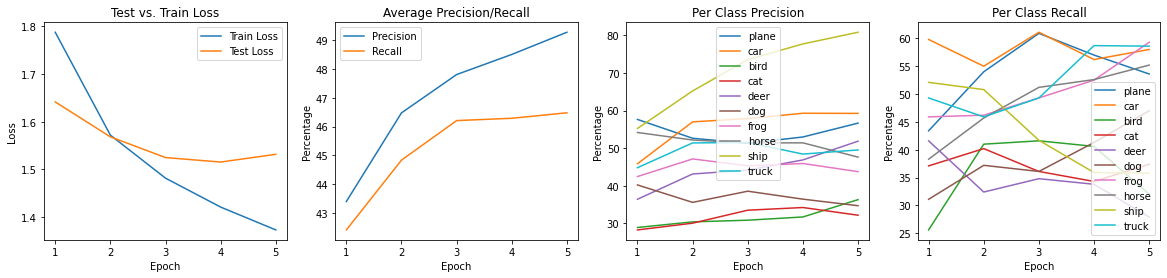

In [111]:
fc_net_config = {
    'name' : 'FullyConnectedNetwork_1x128_LR1e-3_M09_BN',
    'layer_sizes' : [(3*32*32,64),(64,64),(64,10)],
    'activation_function' : nn.ReLU(),
    'batch_norm' : True
}
fc_net = FullyConnectedNetwork(fc_net_config).to(device)
print(fc_net)

loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(fc_net.parameters(), lr=1e-3, momentum=0.9)

train_losses, test_results = train_with_early_stopping(train_dataloader, test_dataloader, fc_net, loss_fn, optimiser)

plot_results(train_losses, test_results)

#### `AlexNet32x32`, no Batch Norm

AlexNet32x32(
  (conv_stack): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): Identity()
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (5): Identity()
    (6): ReLU()
    (7): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): Identity()
    (10): ReLU()
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (12): Identity()
    (13): ReLU()
    (14): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (15): Identity()
    (16): ReLU()
    (17): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_stack): Sequential(
    (0): Linear(in_features=6400, out_features=4096, bias=True)
    (1): Identity()
    (2): ReLU()
    (3): Dropout(p=0.5, inplace

loss: 1.424662  [ 6400/50000]
loss: 1.120629  [12800/50000]
loss: 1.405867  [19200/50000]
loss: 1.411140  [25600/50000]
loss: 1.500182  [32000/50000]
loss: 1.426999  [38400/50000]
loss: 1.401221  [44800/50000]
Average loss this epoch: 1.371652
Class: 0, Precision: 56.65%, Recall: 61.30
Class: 1, Precision: 46.31%, Recall: 84.20
Class: 2, Precision: 48.67%, Recall: 20.20
Class: 3, Precision: 33.51%, Recall: 32.30
Class: 4, Precision: 53.27%, Recall: 28.50
Class: 5, Precision: 42.97%, Recall: 47.10
Class: 6, Precision: 59.35%, Recall: 62.50
Class: 7, Precision: 60.59%, Recall: 61.20
Class: 8, Precision: 58.27%, Recall: 62.00
Class: 9, Precision: 44.86%, Recall: 43.20
Average Precision: 50.45%, Average Recall: 50.25%
Test Error: 
 Accuracy: 50.2%, Avg loss: 1.363923 

---------- Epoch 11 ---------
loss: 1.383950  [    0/50000]
loss: 1.248742  [ 6400/50000]
loss: 1.126366  [12800/50000]
loss: 1.284222  [19200/50000]
loss: 1.296810  [25600/50000]
loss: 1.406107  [32000/50000]
loss: 1.297577

loss: 0.770785  [ 6400/50000]
loss: 0.759169  [12800/50000]
loss: 0.753388  [19200/50000]
loss: 0.832856  [25600/50000]
loss: 0.888267  [32000/50000]
loss: 0.846885  [38400/50000]
loss: 0.979575  [44800/50000]
Average loss this epoch: 0.832398
Class: 0, Precision: 78.52%, Recall: 60.30
Class: 1, Precision: 82.82%, Recall: 78.10
Class: 2, Precision: 59.16%, Recall: 52.30
Class: 3, Precision: 40.40%, Recall: 46.30
Class: 4, Precision: 61.89%, Recall: 55.70
Class: 5, Precision: 51.78%, Recall: 59.70
Class: 6, Precision: 65.14%, Recall: 79.60
Class: 7, Precision: 71.09%, Recall: 71.80
Class: 8, Precision: 84.67%, Recall: 72.90
Class: 9, Precision: 72.42%, Recall: 80.60
Average Precision: 66.79%, Average Recall: 65.73%
Test Error: 
 Accuracy: 65.7%, Avg loss: 0.980074 

---------- Epoch 21 ---------
loss: 0.732508  [    0/50000]
loss: 0.721156  [ 6400/50000]
loss: 0.734664  [12800/50000]
loss: 0.750407  [19200/50000]
loss: 0.807742  [25600/50000]
loss: 0.949356  [32000/50000]
loss: 0.749442

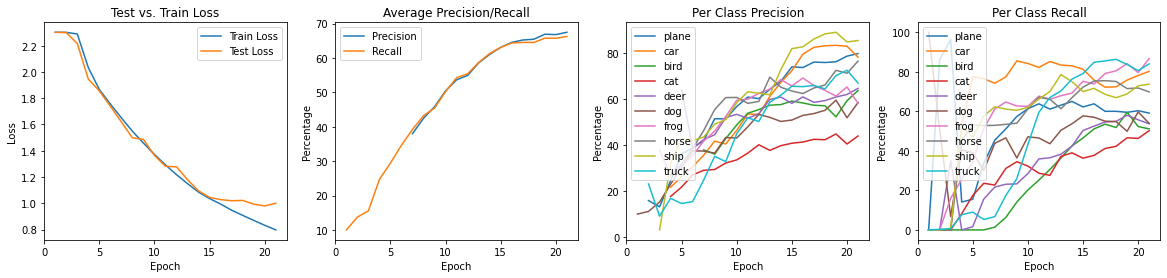

In [113]:
an_config = {
    'name' : 'AlexNet32x32_defFeatures_LR1e-3_M09',
    'batch_norm' : False,
    'small_features': 96, # default: 96
    'medium_features': 256,# default: 256
    'large_features': 384, # default: 384
    'fullyconnected_features': 4096 # default: 4096
}

a_net = AlexNet32x32(an_config)
a_net.to(device)
print(a_net)

loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(a_net.parameters(), lr=1e-3, momentum=0.9)

train_losses, test_results = train_with_early_stopping(train_dataloader, test_dataloader, a_net, loss_fn, optimiser)

plot_results(train_losses, test_results)

#### `AlexNet32x32`, Larger Learning Rate

AlexNet32x32(
  (conv_stack): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): Identity()
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (5): Identity()
    (6): ReLU()
    (7): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): Identity()
    (10): ReLU()
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (12): Identity()
    (13): ReLU()
    (14): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (15): Identity()
    (16): ReLU()
    (17): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_stack): Sequential(
    (0): Linear(in_features=6400, out_features=4096, bias=True)
    (1): Identity()
    (2): ReLU()
    (3): Dropout(p=0.5, inplace

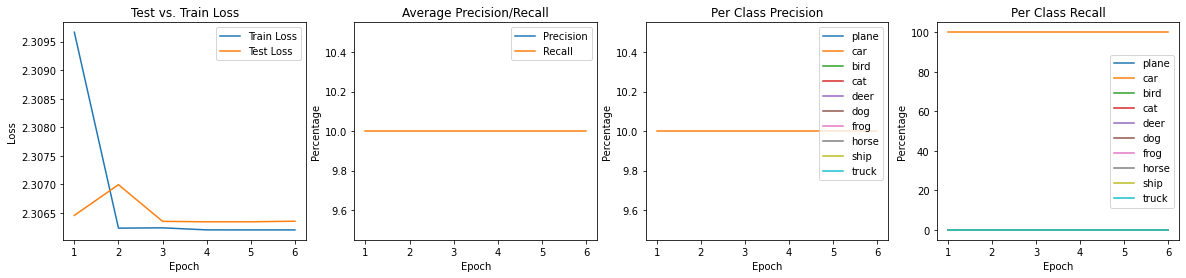

In [114]:
an_config = {
    'name' : 'AlexNet32x32_defFeatures_LR1e-1_M09',
    'batch_norm' : False,
    'small_features': 96, # default: 96
    'medium_features': 256,# default: 256
    'large_features': 384, # default: 384
    'fullyconnected_features': 4096 # default: 4096
}

a_net = AlexNet32x32(an_config)
a_net.to(device)
print(a_net)

loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(a_net.parameters(), lr=1e-1, momentum=0.9)

train_losses, test_results = train_with_early_stopping(train_dataloader, test_dataloader, a_net, loss_fn, optimiser)

plot_results(train_losses, test_results)

#### `AlexNet32x32`, with Batch Norm

AlexNet32x32(
  (conv_stack): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (

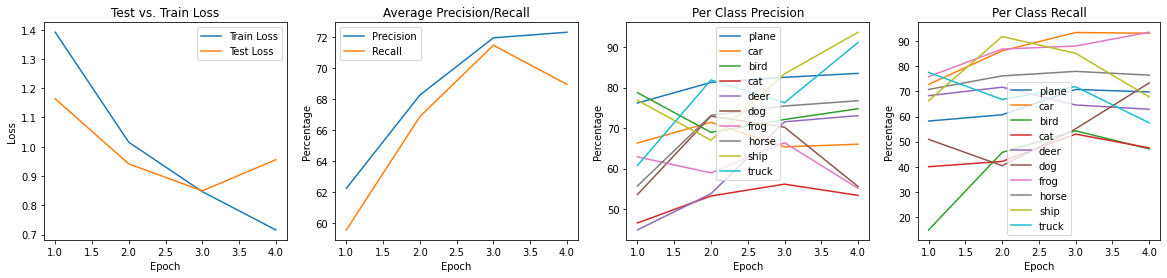

In [115]:
an_config = {
    'name' : 'AlexNet32x32_defFeatures_LR1e-3_M09_BN',
    'batch_norm' : True,
    'small_features': 96, # default: 96
    'medium_features': 256,# default: 256
    'large_features': 384, # default: 384
    'fullyconnected_features': 4096 # default: 4096
}

a_net = AlexNet32x32(an_config)
a_net.to(device)
print(a_net)

loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(a_net.parameters(), lr=1e-3, momentum=0.9)

train_losses, test_results = train_with_early_stopping(train_dataloader, test_dataloader, a_net, loss_fn, optimiser)

plot_results(train_losses, test_results)

#### `AlexNet32x32`, reduced number of features

AlexNet32x32(
  (conv_stack): Sequential(
    (0): Conv2d(3, 8, kernel_size=(7, 7), stride=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 24, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (5): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(24, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Conv2d(64, 24, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (15): BatchNor

loss: 1.075239  [ 6400/50000]
loss: 0.942887  [12800/50000]
loss: 0.927445  [19200/50000]
loss: 1.069242  [25600/50000]
loss: 1.183819  [32000/50000]
loss: 0.908866  [38400/50000]
loss: 1.050241  [44800/50000]
Average loss this epoch: 0.998187
Class: 0, Precision: 72.35%, Recall: 68.30
Class: 1, Precision: 74.47%, Recall: 77.60
Class: 2, Precision: 69.10%, Recall: 39.80
Class: 3, Precision: 48.62%, Recall: 36.90
Class: 4, Precision: 55.26%, Recall: 62.00
Class: 5, Precision: 64.85%, Recall: 44.10
Class: 6, Precision: 58.96%, Recall: 80.30
Class: 7, Precision: 58.71%, Recall: 77.20
Class: 8, Precision: 77.00%, Recall: 76.00
Class: 9, Precision: 63.23%, Recall: 76.70
Average Precision: 64.25%, Average Recall: 63.89%
Test Error: 
 Accuracy: 63.9%, Avg loss: 1.039383 

---------- Epoch 10 ---------
loss: 0.961361  [    0/50000]
loss: 1.009575  [ 6400/50000]
loss: 0.880460  [12800/50000]
loss: 0.836628  [19200/50000]
loss: 1.075637  [25600/50000]
loss: 1.021858  [32000/50000]
loss: 0.993813

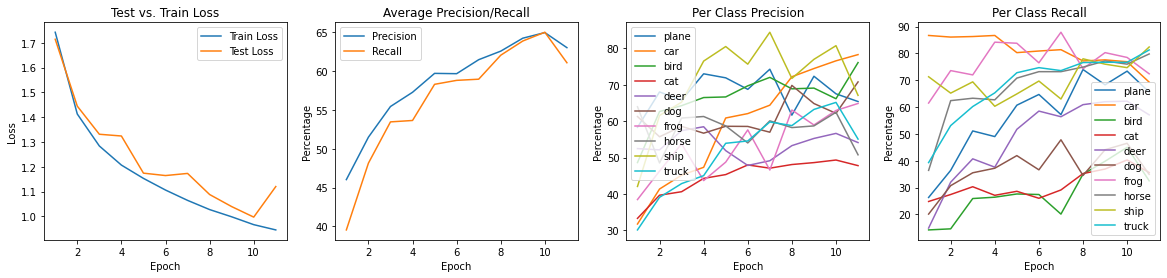

In [116]:
an_config = {
    'name' : 'AlexNet32x32_reducedFeatures_LR1e-3_M09_BN',
    'batch_norm' : True,
    'small_features': 8, # default: 96
    'medium_features': 24,# default: 256
    'large_features': 64, # default: 384
    'fullyconnected_features': 512 # default: 4096
}

a_net = AlexNet32x32(an_config)
a_net.to(device)
print(a_net)

loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(a_net.parameters(), lr=1e-3, momentum=0.9)

train_losses, test_results = train_with_early_stopping(train_dataloader, test_dataloader, a_net, loss_fn, optimiser)

plot_results(train_losses, test_results)

#### `AlexNet32x32`, medium number of features

AlexNet32x32(
  (conv_stack): Sequential(
    (0): Conv2d(3, 48, kernel_size=(7, 7), stride=(2, 2))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (4): Conv2d(48, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (

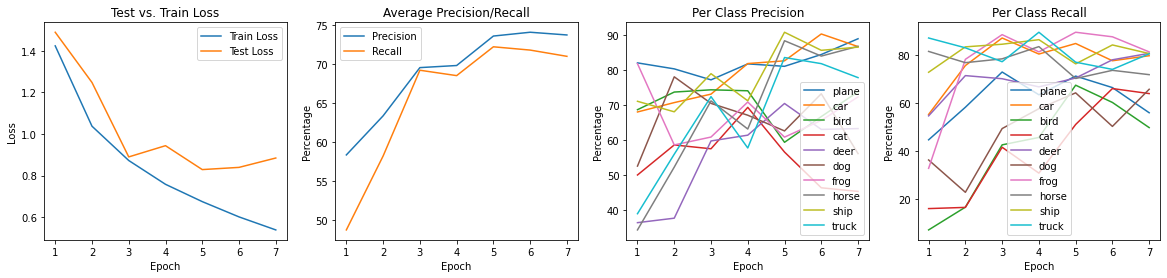

In [126]:
an_config = {
    'name' : 'AlexNet32x32_medFeatures_LR1e-3_M09_BN',
    'batch_norm' : True,
    'small_features': 48, # default: 96
    'medium_features': 128,# default: 256
    'large_features': 256, # default: 384
    'fullyconnected_features': 2048 # default: 4096
}

a_net = AlexNet32x32(an_config)
a_net.to(device)
print(a_net)

loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(a_net.parameters(), lr=1e-3, momentum=0.9)

train_losses, test_results = train_with_early_stopping(train_dataloader, test_dataloader, a_net, loss_fn, optimiser)

plot_results(train_losses, test_results)

#### `VGG1632x32`, no Batch Norm

VGG1632x32(
  (conv_stack): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Identity()
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): Identity()
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (8): Identity()
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (11): Identity()
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (15): Identity()
    (16): ReLU()
    (17): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (18): Identity()
    (19): ReLU()
    (20): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (21): Identity()
    (22): ReLU()
    (23)

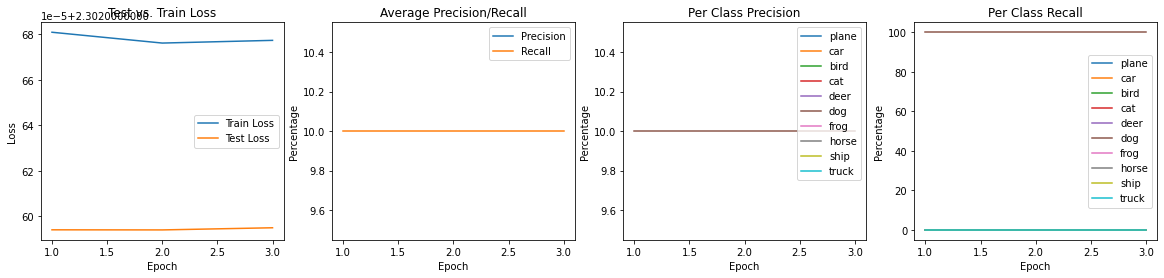

In [117]:
vgg_net_config = {
    'name' : 'VGG1632x32_defFeatures_LR1e-3_M09',
    'batch_norm' : False,
    'conv1_features': 64, #default: 64
    'conv2_features': 128,#default: 128
    'conv3_features': 256,#default: 256
    'conv4_features': 512,#default: 512
    'conv5_features': 512,#default: 512
    'fullyconnected_features': 4096 #default: 4096
}

vgg_net = VGG1632x32(vgg_net_config)
vgg_net.to(device)
print(vgg_net)

loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(vgg_net.parameters(), lr=1e-3, momentum=0.9)

train_losses, test_results = train_with_early_stopping(train_dataloader, test_dataloader, vgg_net, loss_fn, optimiser)

plot_results(train_losses, test_results)

#### `VGG1632x32`, Larger Learning Rate

VGG1632x32(
  (conv_stack): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Identity()
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): Identity()
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (8): Identity()
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (11): Identity()
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (15): Identity()
    (16): ReLU()
    (17): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (18): Identity()
    (19): ReLU()
    (20): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (21): Identity()
    (22): ReLU()
    (23)

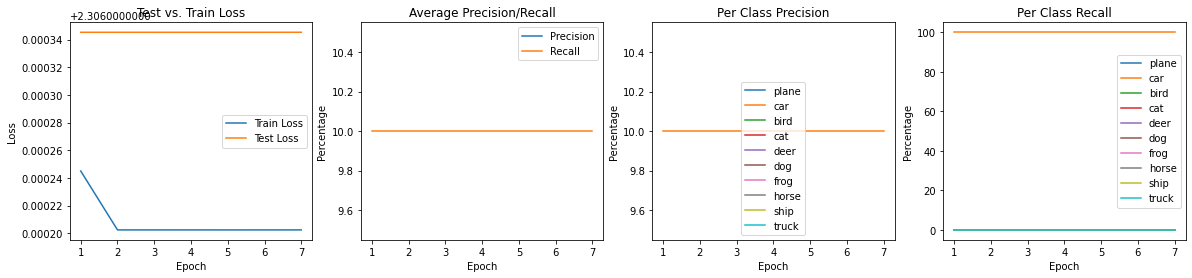

In [118]:
vgg_net_config = {
    'name' : 'VGG1632x32_defFeatures_LR1e-1_M09',
    'batch_norm' : False,
    'conv1_features': 64, #default: 64
    'conv2_features': 128,#default: 128
    'conv3_features': 256,#default: 256
    'conv4_features': 512,#default: 512
    'conv5_features': 512,#default: 512
    'fullyconnected_features': 4096 #default: 4096
}

vgg_net = VGG1632x32(vgg_net_config)
vgg_net.to(device)
print(vgg_net)

loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(vgg_net.parameters(), lr=1e-1, momentum=0.9)

train_losses, test_results = train_with_early_stopping(train_dataloader, test_dataloader, vgg_net, loss_fn, optimiser)

plot_results(train_losses, test_results)

#### `VGG1632x32`, with Batch Norm

VGG1632x32(
  (conv_stack): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=sa

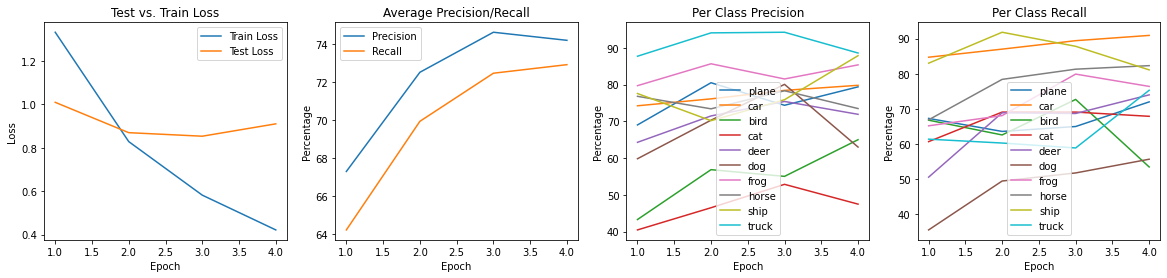

In [121]:
vgg_net_config = {
    'name' : 'VGG1632x32_defFeatures_LR1e-3_M09_BN',
    'batch_norm' : True,
    'conv1_features': 64, #default: 64
    'conv2_features': 128,#default: 128
    'conv3_features': 256,#default: 256
    'conv4_features': 512,#default: 512
    'conv5_features': 512,#default: 512
    'fullyconnected_features': 4096 #default: 4096
}

vgg_net = VGG1632x32(vgg_net_config)
vgg_net.to(device)
print(vgg_net)

loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(vgg_net.parameters(), lr=1e-3, momentum=0.9)

train_losses, test_results = train_with_early_stopping(train_dataloader, test_dataloader, vgg_net, loss_fn, optimiser)

plot_results(train_losses, test_results)

#### `VGG1632x32`, reduced number of features

VGG1632x32(
  (conv_stack): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (15):

loss: 0.741512  [ 6400/50000]
loss: 0.635425  [12800/50000]
loss: 0.825037  [19200/50000]
loss: 0.744854  [25600/50000]
loss: 0.893659  [32000/50000]
loss: 0.624929  [38400/50000]
loss: 0.820847  [44800/50000]
Average loss this epoch: 0.754434
Class: 0, Precision: 64.52%, Recall: 75.10
Class: 1, Precision: 69.73%, Recall: 87.30
Class: 2, Precision: 54.42%, Recall: 48.00
Class: 3, Precision: 37.33%, Recall: 57.60
Class: 4, Precision: 59.36%, Recall: 57.40
Class: 5, Precision: 59.66%, Recall: 42.60
Class: 6, Precision: 74.02%, Recall: 71.50
Class: 7, Precision: 69.73%, Recall: 66.80
Class: 8, Precision: 79.47%, Recall: 74.30
Class: 9, Precision: 86.59%, Recall: 53.60
Average Precision: 65.48%, Average Recall: 63.42%
Test Error: 
 Accuracy: 63.4%, Avg loss: 1.068762 

---------- Epoch 8 ---------
loss: 0.636467  [    0/50000]
loss: 0.632508  [ 6400/50000]
loss: 0.565089  [12800/50000]
loss: 0.764220  [19200/50000]
loss: 0.734534  [25600/50000]
loss: 0.828418  [32000/50000]
loss: 0.612555 

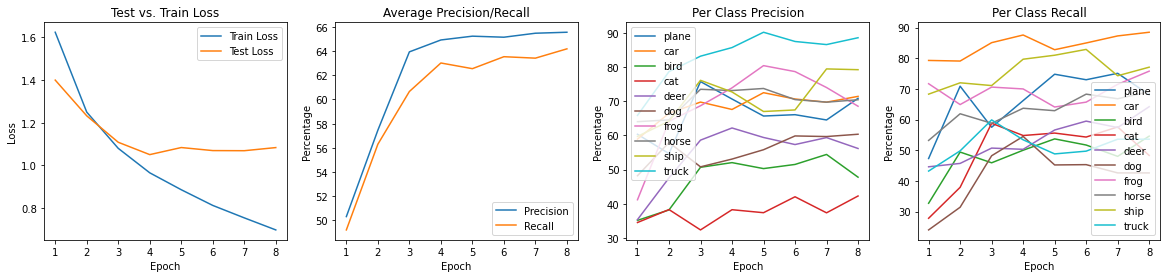

In [127]:
vgg_net_config = {
    'name' : 'VGG1632x32_reducedFeatures_LR1e-3_M09_BN',
    'batch_norm' : True,
    'conv1_features': 8, #default: 64
    'conv2_features': 16,#default: 128
    'conv3_features': 32,#default: 256
    'conv4_features': 64,#default: 512
    'conv5_features': 64,#default: 512
    'fullyconnected_features': 512 #default: 4096
}

vgg_net = VGG1632x32(vgg_net_config)
vgg_net.to(device)
print(vgg_net)

loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(vgg_net.parameters(), lr=1e-3, momentum=0.9)

train_losses, test_results = train_with_early_stopping(train_dataloader, test_dataloader, vgg_net, loss_fn, optimiser)

plot_results(train_losses, test_results)

#### `VGG1632x32`, medium number of features

VGG1632x32(
  (conv_stack): Sequential(
    (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (8): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (11): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=same)
  

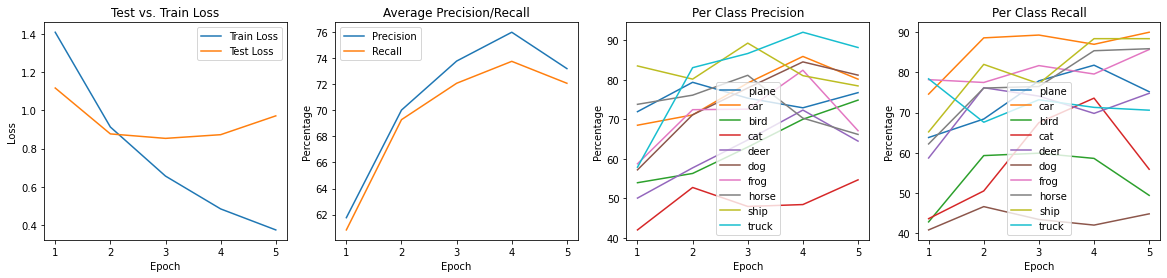

In [130]:
vgg_net_config = {
    'name' : 'VGG1632x32_medFeatures_LR1e-3_M09_BN',
    'batch_norm' : True,
    'conv1_features': 48, #default: 64
    'conv2_features': 96,#default: 128
    'conv3_features': 192,#default: 256
    'conv4_features': 384,#default: 512
    'conv5_features': 384,#default: 512
    'fullyconnected_features': 3072 #default: 4096
}

vgg_net = VGG1632x32(vgg_net_config)
vgg_net.to(device)
print(vgg_net)

loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(vgg_net.parameters(), lr=1e-3, momentum=0.9)

train_losses, test_results = train_with_early_stopping(train_dataloader, test_dataloader, vgg_net, loss_fn, optimiser)

plot_results(train_losses, test_results)